We analyse how the Koopman eigenfunctions look when only parts of the state space are explored.
We then study the discrepancies between the partially informed koopman functions and their trajectory based estimation step.

We hope to distil a heuristic on how to choose adaptively new sample points for the exploration of the phase space.

Conjecture 1: High variance in the koopman expectation indicates a transition region.
Conjecture 2: We want more samples where we have transitions (=bottlenecks) and we want samples where the current approximation is bad (we already speed up learning here by the use of mse loss (gradient proportional to residual))

In [38]:
include("sqra.jl")
using Arpack
using Plots
Matrix(v::Vector) = reshape(v, length(v), 1)

Matrix{T} where T (alias for Array{T, 2} where T)

In [225]:
include("isokann.jl");
include("neurcomm.jl")

In [426]:
dist = 1.5
dx = .02
xs = -dist:dx:dist
potential(x) = sum(@. (x^2-1)^2)
sigma = 0.5
beta = 2 / sigma^2
U  = [potential(x) for x in xs]
Q  = sqra(Matrix(U), beta);

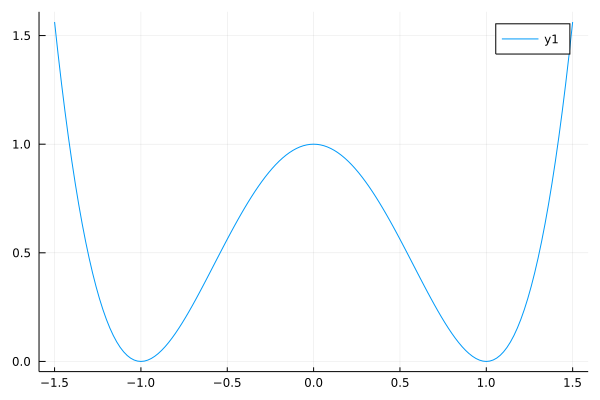

In [427]:
plot(xs, U)

niter = 47


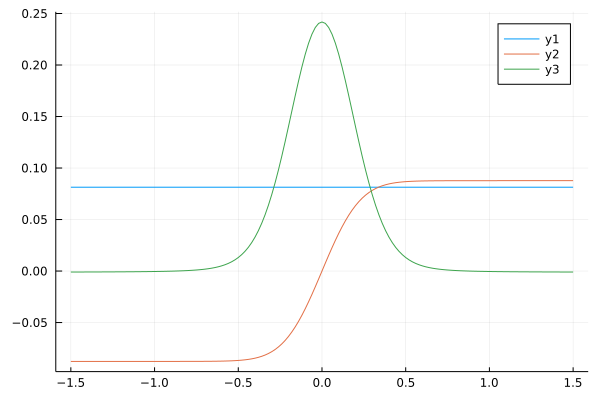

In [428]:
λ, ϕ, nconv,niter,nmult,resid = eigs(Q, which=:LR, maxiter=3000)
@show niter
plot(xs, ϕ[:,1:3] |> real)

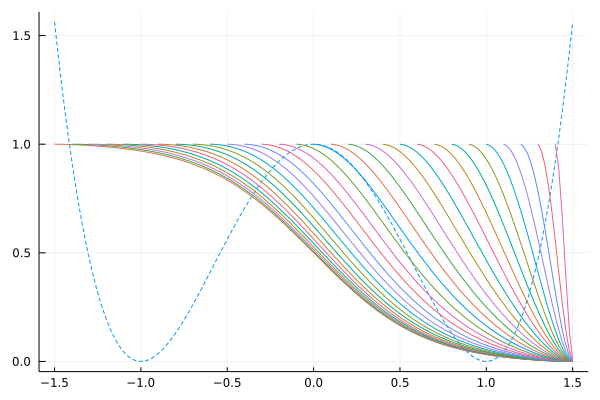

In [547]:
p=plot(xs, U, legend=false, style=:dash)
koopmans = []
koopmanxs = []
for i=1:5:size(Q,1)-3
    QQ  = sqra(Matrix(U[i:end]), 1);
    λ, ϕ, nconv,niter,nmult,resid = eigs(QQ, which=:LR, nev=3)
    χ = ϕ[:,2] |> real
    χ = χ * sign(χ[1] - χ[end])
    χ = shiftscale(χ)
    
    push!(koopmans, χ)
    push!(koopmanxs, xs[i:end])
    
    plot!(xs[i:end], χ)
end
p

In [548]:
# we need this in some module
# maybe the argumetns should work in time not no of steps, i.e. stepsize, duration, saveintervals

function eulermarujamatrajectories(x0::Matrix, potential::Function, sigma::Real, dt::Real, steps::Integer; branches::Integer=1)
    dim, samples = size(x0)
    xts = similar(x0, dim, steps+1, branches, samples)
    for s in 1:samples
        for b in 1:branches
            x = x0[:, s]
            xts[:, 1, b, s] = x
            for t in 2:steps+1
                g = Zygote.gradient(potential, x)[1]
                x .+= -g * dt .+ sigma * randn(dim) * sqrt(dt)
                xts[:, t, b, s] = x
            end
        end
    end
    xts
end


x0 = rand(1,1) * 3 .- 1.5
trajs = eulermarujamatrajectories(x0, potential, sigma, .1, 100000, branches=1)

1×100001×1×1 Array{Float64, 4}:
[:, :, 1, 1] =
 0.17818  0.256465  0.391955  0.52579  …  1.04799  1.07316  1.10616  1.2881

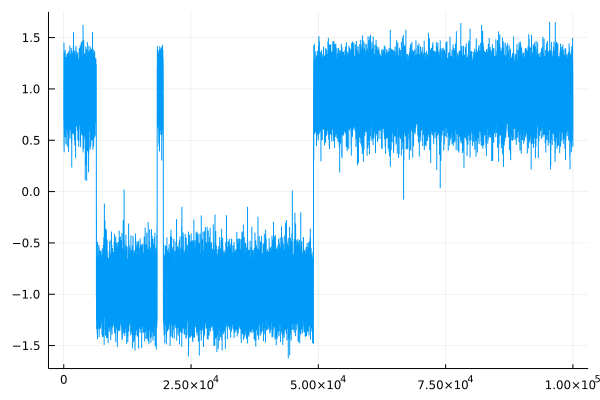

In [519]:
plot(trajs[1,:,1,1], legend=false)

In [575]:
x0 = reshape(collect(xs), 1, length(xs))
trajs = eulermarujamatrajectories(x0, potential, sigma, .1, 100, branches=100)

1×101×100×151 Array{Float64, 4}:
[:, :, 1, 1] =
 -1.5  -1.00614  -1.03867  -1.10878  …  -1.1822  -1.10705  -0.930692

[:, :, 2, 1] =
 -1.5  -0.818512  -0.935726  -1.07483  …  -0.863833  -0.829089  -1.06937

[:, :, 3, 1] =
 -1.5  -0.645972  -1.01421  -0.895833  …  -1.00006  -0.898018  -0.92381

...

[:, :, 98, 1] =
 -1.5  -0.660212  -0.92234  -1.02955  …  -1.08131  -0.772338  -0.838293

[:, :, 99, 1] =
 -1.5  -0.892475  -0.987748  -0.938992  …  -0.728327  -0.813309  -0.872263

[:, :, 100, 1] =
 -1.5  -0.367731  -0.480717  -0.542966  …  -0.566035  -0.678309  -0.874953

[:, :, 1, 2] =
 -1.48  -1.08039  -0.941615  -0.895528  …  -0.721168  -0.95512  -1.02576

[:, :, 2, 2] =
 -1.48  -0.699916  -0.97629  -1.02085  …  -0.868236  -1.01837  -1.30857

[:, :, 3, 2] =
 -1.48  -0.663288  -0.503778  -0.852678  …  -1.066  -0.871692  -0.993974

...

[:, :, 98, 2] =
 -1.48  -0.76665  -0.901484  -0.948655  …  -1.08769  -0.841249  -1.0831

[:, :, 99, 2] =
 -1.48  -0.641627  -0.813448  -1.18001  …  -1.1239

In [576]:
function gridfunction(grid, values)
    grid = grid .+ step(grid) / 2
    function (x)
        x < grid[1] && return values[1]
        i = findfirst(y->y>x, grid)
        i == nothing && return values[end]
        return values[i]
    end
end

gridfunction (generic function with 1 method)

In [577]:
kf = gridfunction(koopmanxs[1], koopmans[1])

#256 (generic function with 1 method)

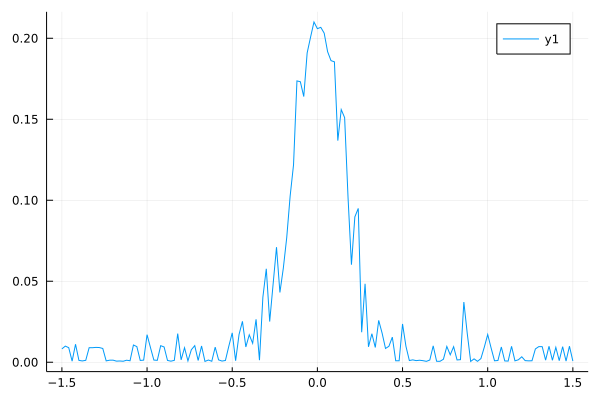

In [578]:
plot(xs, var(kf.(trajs[1,end,:,:]), dims=1) |> vec)

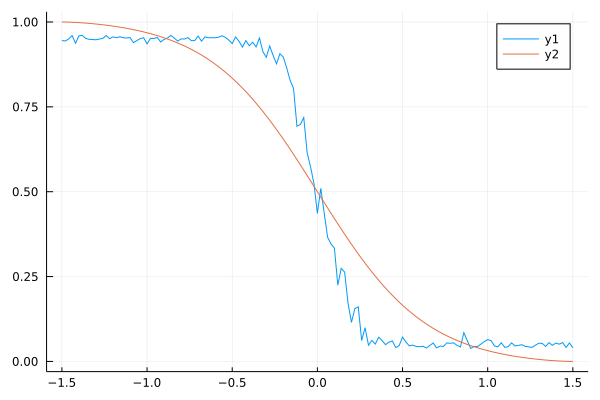

In [583]:
plot(xs, mean(kf.(trajs[1,end,:,:]), dims=1) |> vec)
plot!(xs, kf)

In [ ]:
# todo, fit the timescales so that the above plots lie together
# then: do this analysis but with partially informed koopmans, and check if we can learn something from the discrepancies